In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Any results you write to the current directory are saved as output.


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


> ### Load Data

In [5]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
print('Train size: ', df_train.shape)
print('Test size: ', df_test.shape)
df_train.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/train.csv'

### Calculate mean and std of training data - used for normalization later

In [ ]:
train_data = df_train.drop('label', axis=1).values
# train_data.shape
# print(train_data.max())
train_mean = train_data.mean()/255.
train_std = train_data.std()/255.
# train_std
print('Mean: ', train_mean)
print('Std: ', train_std)

Mean:  0.13101533792088266
Std:  0.3085401559245608


### Split training data into training-validation

In [ ]:
# Train-Val split
mask = np.random.rand(len(df_train)) < 0.8
df_val = df_train[~mask]
df_train = df_train[mask]
print('Train size: ', df_train.shape)
print('Val size: ', df_val.shape)
print('Test size: ', df_test.shape)
df_train.head()

Train size:  (33701, 785)
Val size:  (8299, 785)
Test size:  (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Visualize Example

Text(0.5, 1.0, '1')

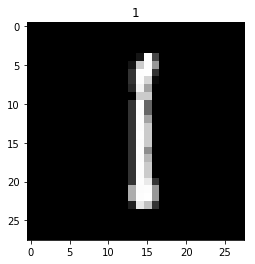

In [ ]:
import matplotlib.pyplot as plt
ind = np.random.randint(0, df_train.shape[0]-1)
plt.imshow(df_train.iloc[ind].values[1:].reshape((28,28)), cmap='gray')
plt.title(str(df_train.iloc[ind][0]))

### Define a PyTorch Dataset

In [ ]:
# Create dataset class for PyTorch
class MNISTDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, n):
        data = self.df.iloc[n]
        image = data[1:].values.reshape((28,28)).astype(np.uint8)
        label = data[0]
        if self.transform:
            image = self.transform(image)
        return (image, label)

### Define data augmentation and data loaders

In [ ]:
# Initialize transformation, datasets, and loaders
batch_size = 16
classes = range(10)
train_transform = transforms.Compose(
                    [
                    transforms.ToPILImage(),
#                     transforms.RandomRotation(30),
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[train_mean], std=[train_std]),
                    ])
# don't (really) need the data augmentation in validation
val_transform = transforms.Compose(
                    [
                    transforms.ToPILImage(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[train_mean], std=[train_std]),
                    ])
test_transform = val_transform

train_dataset = MNISTDataset(df_train, transform = train_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                batch_size=batch_size,shuffle = True)
val_dataset = MNISTDataset(df_val, transform = val_transform)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                batch_size=batch_size,shuffle = False)



### Sanity check to make sure data is of normal distribution (zero mean and unit standard dev)

tensor(-0.4246)
tensor(2.8164)
tensor(-0.0073)
tensor(0.9439)
6


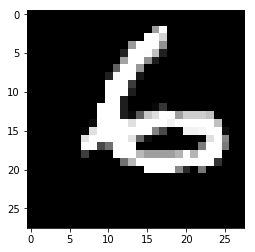

In [ ]:
# sanity check for training data
imgs, lbls = next(iter(train_loader))
imgs[7].data.shape
print(imgs.data.min())
print(imgs.data.max())
print(imgs.data.mean())
print(imgs.data.std())
print(classes[lbls[0]])
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

tensor(-0.4246)
tensor(2.8164)
tensor(-0.0921)
tensor(0.9046)
1


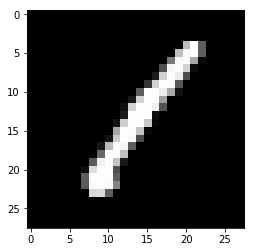

In [ ]:
# sanity check for validation data
imgs, lbls = next(iter(val_loader))
imgs[0].data.shape
print(imgs.data.min())
print(imgs.data.max())
print(imgs.data.mean())
print(imgs.data.std())
print(classes[lbls[0]])
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

### Define CNN Architecture: 
I used 3 conv layers plus 3 fully connected layers with ReLU activation. Dropout and batch normalization were also used.

Update: I borrowed a deeper model architecture from [this kernel](https://www.kaggle.com/gustafsilva/cnn-digit-recognizer-pytorch).

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1_1 = nn.Conv2d(1, 32, 3, padding=1)
        self.relu1_1 = nn.ReLU()
        self.batchnorm1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, 3, padding=1)
        self.relu1_2 = nn.ReLU()
        self.batchnorm1_2 = nn.BatchNorm2d(32)
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.relu1_3 = nn.ReLU()
        self.batchnorm1_3 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv2_1 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2_1 = nn.ReLU()
        self.batchnorm2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu2_2 = nn.ReLU()
        self.batchnorm2_2 = nn.BatchNorm2d(64)
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.relu2_3 = nn.ReLU()
        self.batchnorm2_3 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.conv3_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu3_1 = nn.ReLU()
        self.batchnorm3_1 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)
        
        self.fc = nn.Linear(128, 10)
                
        
    def forward(self, x):
        x = self.conv1_1(x)
        x = self.relu1_1(x)
        x = self.batchnorm1_1(x)
        x = self.conv1_2(x)
        x = self.relu1_2(x)
        x = self.batchnorm1_2(x)
        x = self.conv1_3(x)
        x = self.relu1_3(x)
        x = self.batchnorm1_3(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = self.conv2_1(x)
        x = self.relu2_1(x)
        x = self.batchnorm2_1(x)
        x = self.conv2_2(x)
        x = self.relu2_2(x)
        x = self.batchnorm2_2(x)
        x = self.conv2_3(x)
        x = self.relu2_3(x)
        x = self.batchnorm2_3(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = self.conv3_1(x)
        x = self.relu3_1(x)
        x = self.batchnorm3_1(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

# Instantiate the model
model = Model()


### Model Training

In [10]:
# initialize CNN, cost, and optimizer
model = Model()
model.to(device)
criterion = nn.NLLLoss()   # with log_softmax() as the last layer, this is equivalent to cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
model

Model(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (batchnorm1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (batchnorm1_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu1_3): ReLU()
  (batchnorm1_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (batchnorm2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [12]:
# Training Time!
import time
import copy

# Some initialization work first...
epochs = 100
train_losses, val_losses = [], []
train_accu, val_accu = [], []
start_time = time.time()
early_stop_counter = 10   # stop when the validation loss does not improve for 10 iterations to prevent overfitting
counter = 0
best_val_loss = float('Inf')

for e in range(epochs):
    epoch_start_time = time.time()
    running_loss = 0
    accuracy=0
    # training step
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        
        ps = torch.exp(log_ps)                
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # record training loss and error, then evaluate using validation data
    train_losses.append(running_loss/len(train_loader))
    train_accu.append(accuracy/len(train_loader))
    val_loss = 0
    accuracy=0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            log_ps = model(images)
            val_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    val_losses.append(val_loss/len(val_loader))
    val_accu.append(accuracy/len(val_loader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Time: {:.2f}s..".format(time.time()-epoch_start_time),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Training Accu: {:.3f}.. ".format(train_accu[-1]),
          "Val Loss: {:.3f}.. ".format(val_losses[-1]),
          "Val Accu: {:.3f}".format(val_accu[-1]))

#     print('Epoch %d / %d took %6.2f seconds' % (e+1, epochs, time.time()-epoch_start_time))
#     print('Total training time till this epoch was %8.2f seconds' % (time.time()-start_time))
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter=0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        counter+=1
        print('Validation loss has not improved since: {:.3f}..'.format(best_val_loss), 'Count: ', str(counter))
        if counter >= early_stop_counter:
            print('Early Stopping Now!!!!')
            model.load_state_dict(best_model_wts)
            break
        

NameError: name 'train_loader' is not defined

In [13]:
# plot training history
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, e + 2])
plt.ylabel('Loss')
plt.plot(range(1, e + 2), train_losses[:e+1], 'r', label='Training Loss')
plt.plot(range(1, e + 2), val_losses[:e+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, e+2])
plt.ylabel('Accuracy')
plt.plot(range(1, e + 2), train_accu[:e+1], 'r', label='Training Accuracy')
plt.plot(range(1, e + 2), val_accu[:e+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

### Prediction

In [ ]:
# prepare to predict test data - REMEMBER PRE-PROCESSING!
# I originally forgot to scale and normalize, which caused problems....

# some sanity check to make sure
x_test = df_test.values
x_test = x_test.reshape([-1, 28, 28]).astype(np.float)
x_test = x_test/255.
x_test = (x_test-train_mean)/train_std
print(x_test.min())
print(x_test.max())
print(x_test.mean())
print(x_test.std())

In [ ]:
# x_test = df_test.values
# x_test = x_test.reshape([-1, 28, 28]).astype(np.float)
# x_test = x_test/255.
# x_test = (x_test-train_mean)/train_std
x_test = np.expand_dims(x_test, axis=1)
x_test = torch.from_numpy(x_test).float().to(device)
# x_test.shape
x_test.type()

In [ ]:
# prediction time!
model.eval()   # this is needed to disable dropouts
with torch.no_grad():    # turn off gradient computation because we don't need it for prediction
    ps = model(x_test)
    prediction = torch.argmax(ps, 1)
    print('Prediction',prediction)

In [ ]:
# prepare output file
df_export = pd.DataFrame(prediction.cpu().tolist(), columns = ['Label'])
df_export['ImageId'] = df_export.index +1
df_export = df_export[['ImageId', 'Label']]
df_export.head()

In [ ]:
df_export.to_csv('output.csv', index=False)